In [1]:
import os
from utils.configuration import *
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

In [2]:
experiment_name = "api_ordinal_wine_example"      ## <--- set experiment name
LOG_DIR="/home/bule/TramDag/dev_experiment_logs"  ## <--- set log directory
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

In [3]:
setup_configuration(experiment_name,EXPERIMENT_DIR)

Configuration already exists/home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/configuration.json


In [4]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine

wine = load_wine()
df = pd.DataFrame(wine['data'], columns=wine['feature_names'])
df['target'] = wine['target']

# simulate 1000 samples using Gaussian noise proportional to feature std
X = df.drop(columns='target').values
y = df['target'].values

n_new = 1000 - len(df)
noise_scale = 0.05  # adjust for realism
X_new = []

for _ in range(n_new):
    i = np.random.randint(0, len(X))
    sample = X[i] + np.random.normal(0, noise_scale * X.std(axis=0), X.shape[1])
    X_new.append(sample)

X_new = np.vstack(X_new)
y_new = np.random.choice(y, size=n_new, replace=True)

df_new = pd.DataFrame(X_new, columns=wine['feature_names'])
df_new['target'] = y_new

df_simulated = pd.concat([df, df_new], ignore_index=True)
print(df_simulated.shape)
df_simulated.head()
df=df_simulated

(1000, 14)


In [5]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [6]:
train_df.to_csv(os.path.join(EXPERIMENT_DIR,"train.csv"), index=False)
val_df.to_csv(os.path.join(EXPERIMENT_DIR,"val.csv"), index=False)
test_df.to_csv(os.path.join(EXPERIMENT_DIR,"test.csv"), index=False)

In [7]:
data_type={key:value for key, value in zip(train_df.columns, ['continous']*13+['ordinal_Xc_Yo'])}
data_type

{'alcohol': 'continous',
 'malic_acid': 'continous',
 'ash': 'continous',
 'alcalinity_of_ash': 'continous',
 'magnesium': 'continous',
 'total_phenols': 'continous',
 'flavanoids': 'continous',
 'nonflavanoid_phenols': 'continous',
 'proanthocyanins': 'continous',
 'color_intensity': 'continous',
 'hue': 'continous',
 'od280/od315_of_diluted_wines': 'continous',
 'proline': 'continous',
 'target': 'ordinal_Xc_Yo'}

In [8]:
write_data_type_to_configuration(data_type, CONF_DICT_PATH)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
alcohol              | continous       | continuous [c]                 | continuous [c]                
malic_acid           | continous       | continuous [c]                 | continuous [c]                
ash                  | continous       | continuous [c]                 | continuous [c]                
alcalinity_of_ash    | continous       | continuous [c]                 | continuous [c]                
magnesium            | continous       | continuous [c]                 | continuous [c]                
total_phenols        | continous       | continuous [c]  

/home/bule/TramDag/utils/configuration.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


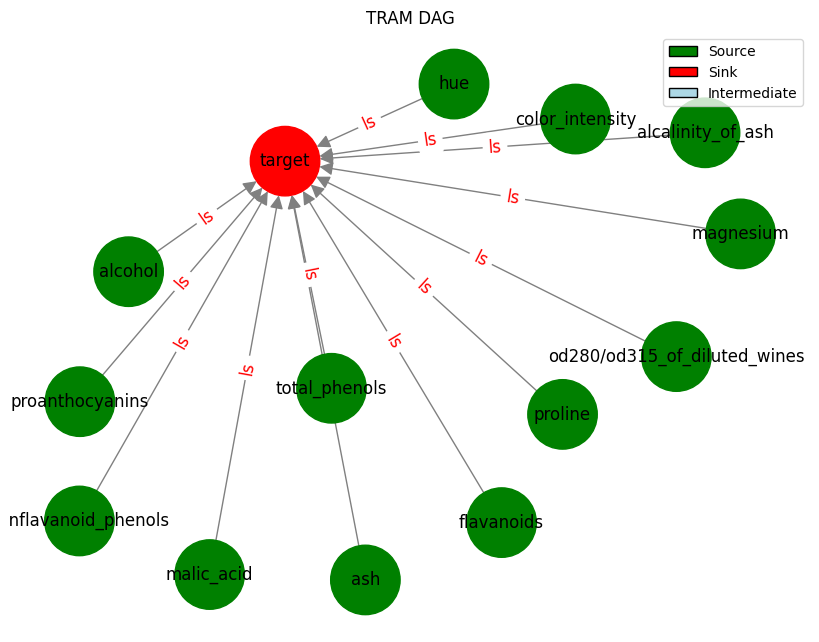

In [9]:
interactive_adj_matrix(CONF_DICT_PATH,seed=19)

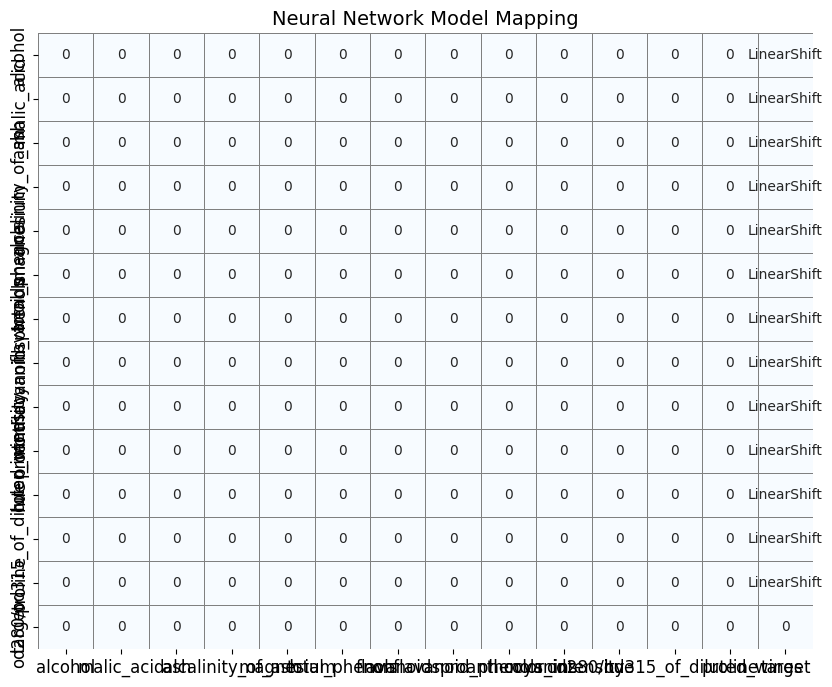

In [10]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

In [11]:
from utils.tramdag import TramDagConfig , TramDagModel

cfg = TramDagConfig.load("/home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/configuration.json")
cfg.compute_levels(train_df)
device='cpu'

In [12]:
td_model = TramDagModel.from_config(cfg, set_initial_weights=False,verbose=True,debug=True,device=device,initial_data = train_df) 
# 1m52s

[DEBUG] TramDagModel using device: cpu

[INFO] Building model for node 'alcohol' with settings: {'set_initial_weights': False, 'debug': True, 'verbose': True, 'device': 'cpu', 'initial_data':        alcohol  malic_acid       ash  alcalinity_of_ash   magnesium  \
29   14.020000    1.680000  2.210000          16.000000   96.000000   
535  11.848528    0.963819  2.557119          17.836826   95.392295   
695  12.885053    2.880808  2.697143          20.856279   94.901448   
557  12.077944    1.139209  2.512308          23.713495   78.206439   
836  13.725321    1.491558  2.720283          19.379836  131.961563   
..         ...         ...       ...                ...         ...   
106  12.250000    1.730000  2.120000          19.000000   80.000000   
270  13.027847    0.910981  1.718224          16.095287   86.604430   
860  13.776740    3.292791  2.540197          20.026933  106.510818   
435  13.289681    4.298289  2.262121          20.243016  121.845804   
102  12.340000    2.450000 

In [ ]:
td_model.fit(train_df, val_df,
            #  train_list=['target'],
             learning_rate=1e-2,
             epochs=200,batch_size=10,
             save_linear_shifts=True,
             verbose=True,debug=False,
             device=device,
             num_workers = 8,
             persistent_workers = True,
             prefetch_factor = 8,
             train_mode = "sequential")#,

#30 eps 1m 49s seq mode from start 1000 bs
#30 eps 2m 27s parllel multiprocessing mode from start 1000 bs
# 200 eps 9m 30s seq mode from start 1000 bs

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/min_max_scaling.json
[INFO] Training 14 nodes (sequential) on cpu

[INFO] Training node 'alcohol' for 200 epochs on cpu (pid=326972)
[INFO] Existing model found. Loading weights and history from LAST model...

===== Epoch 101/200 =====


[INFO] Saved new best model.
[INFO] Epoch 101: Train NLL=1.4365 | Val NLL=1.4884 | Time=0.73s

===== Epoch 102/200 =====
[INFO] Saved new best model.
[INFO] Epoch 102: Train NLL=1.4154 | Val NLL=1.4715 | Time=0.35s

===== Epoch 103/200 =====
[INFO] Saved new best model.
[INFO] Epoch 103: Train NLL=1.3978 | Val NLL=1.4574 | Time=0.36s

===== Epoch 104/200 =====
[INFO] Saved new best model.
[INFO] Epoch 104: Train NLL=1.3820 | Val NLL=1.4460 | Time=0.40s

===== Epoch 105/200 =====
[INFO] Saved new best model.
[INFO] Epoch 105: Train NLL=1.3682 | Val NLL=1.4339 | Time=0.39s

===== Epoch 106/200 =====
[INFO] Saved new best model.
[INFO] Epoch 106: Train NLL=1.3557 | Val NLL=1.4231 | Time=0.42s

===== Epoch 107/200 =====
[INFO] Saved new best model.
[INFO] Epoch 107: Train NLL=1.3437 | Val NLL=1.4142 | Time=0.37s

===== Epoch 108/200 =====
[INFO] Saved new best model.
[INFO] Epoch 108: Train NLL=1.3331 | Val NLL=1.4042 | Time=0.40s

===== Epoch 109/200 =====
[INFO] Saved new best model.
[IN

In [14]:
rsamples, latents = td_model.sample()

[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Deleting all previously sampled data.
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/alcohol/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/malic_acid/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/ash/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/alcalinity_of_ash/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/magnesium/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/total_phenols/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/flavanoids/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/nonflavanoid_phenols/sampling
Dir

[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 45.10it/s]

[INFO] Completed sampling for node 'alcohol'

----*----------*-------------*--------Sample Node: malic_acid ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node malic_acid from standard logistic distribution
[INFO] Loaded best model weights for node 'malic_acid' from /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/malic_acid/best_model.pt
[WARNING] target_col 'malic_acid' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 43.27it/s]

[INFO] Completed sampling for node 'malic_acid'

----*----------*-------------*--------Sample Node: ash ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node ash from standard logistic distribution
[INFO] Loaded best model weights for node 'ash' from /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/ash/best_model.pt
[WARNING] target_col 'ash' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 45.29it/s]

[INFO] Completed sampling for node 'ash'

----*----------*-------------*--------Sample Node: alcalinity_of_ash ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node alcalinity_of_ash from standard logistic distribution
[INFO] Loaded best model weights for node 'alcalinity_of_ash' from /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/alcalinity_of_ash/best_model.pt
[WARNING] target_col 'alcalinity_of_ash' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 44.50it/s]

[INFO] Completed sampling for node 'alcalinity_of_ash'

----*----------*-------------*--------Sample Node: magnesium ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node magnesium from standard logistic distribution
[INFO] Loaded best model weights for node 'magnesium' from /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/magnesium/best_model.pt
[WARNING] target_col 'magnesium' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 45.61it/s]

[INFO] Completed sampling for node 'magnesium'

----*----------*-------------*--------Sample Node: total_phenols ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node total_phenols from standard logistic distribution
[INFO] Loaded best model weights for node 'total_phenols' from /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/total_phenols/best_model.pt
[WARNING] target_col 'total_phenols' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 46.27it/s]

[INFO] Completed sampling for node 'total_phenols'

----*----------*-------------*--------Sample Node: flavanoids ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node flavanoids from standard logistic distribution
[INFO] Loaded best model weights for node 'flavanoids' from /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/flavanoids/best_model.pt
[WARNING] target_col 'flavanoids' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 44.50it/s]

[INFO] Completed sampling for node 'flavanoids'

----*----------*-------------*--------Sample Node: nonflavanoid_phenols ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node nonflavanoid_phenols from standard logistic distribution
[INFO] Loaded best model weights for node 'nonflavanoid_phenols' from /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/nonflavanoid_phenols/best_model.pt
[WARNING] target_col 'nonflavanoid_phenols' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 42.41it/s]

[INFO] Completed sampling for node 'nonflavanoid_phenols'

----*----------*-------------*--------Sample Node: proanthocyanins ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node proanthocyanins from standard logistic distribution
[INFO] Loaded best model weights for node 'proanthocyanins' from /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/proanthocyanins/best_model.pt
[WARNING] target_col 'proanthocyanins' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 47.02it/s]

[INFO] Completed sampling for node 'proanthocyanins'

----*----------*-------------*--------Sample Node: color_intensity ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node color_intensity from standard logistic distribution
[INFO] Loaded best model weights for node 'color_intensity' from /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/color_intensity/best_model.pt
[WARNING] target_col 'color_intensity' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 46.19it/s]

[INFO] Completed sampling for node 'color_intensity'

----*----------*-------------*--------Sample Node: hue ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node hue from standard logistic distribution
[INFO] Loaded best model weights for node 'hue' from /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/hue/best_model.pt
[WARNING] target_col 'hue' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 46.78it/s]

[INFO] Completed sampling for node 'hue'

----*----------*-------------*--------Sample Node: od280/od315_of_diluted_wines ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node od280/od315_of_diluted_wines from standard logistic distribution
[INFO] Loaded best model weights for node 'od280/od315_of_diluted_wines' from /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/od280/od315_of_diluted_wines/best_model.pt
[WARNING] target_col 'od280/od315_of_diluted_wines' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 44.51it/s]

[INFO] Completed sampling for node 'od280/od315_of_diluted_wines'

----*----------*-------------*--------Sample Node: proline ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node proline from standard logistic distribution
[INFO] Loaded best model weights for node 'proline' from /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/proline/best_model.pt
[WARNING] target_col 'proline' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 44.37it/s]

[INFO] Completed sampling for node 'proline'

----*----------*-------------*--------Sample Node: target ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node target from standard logistic distribution
[INFO] Loaded best model weights for node 'target' from /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/target/best_model.pt
[WARNING] target_col 'target' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Completed sampling for node 'target'
[INFO] DAG sampling completed successfully for all nodes.


[INFO] Loaded training/validation histories for 14 nodes.


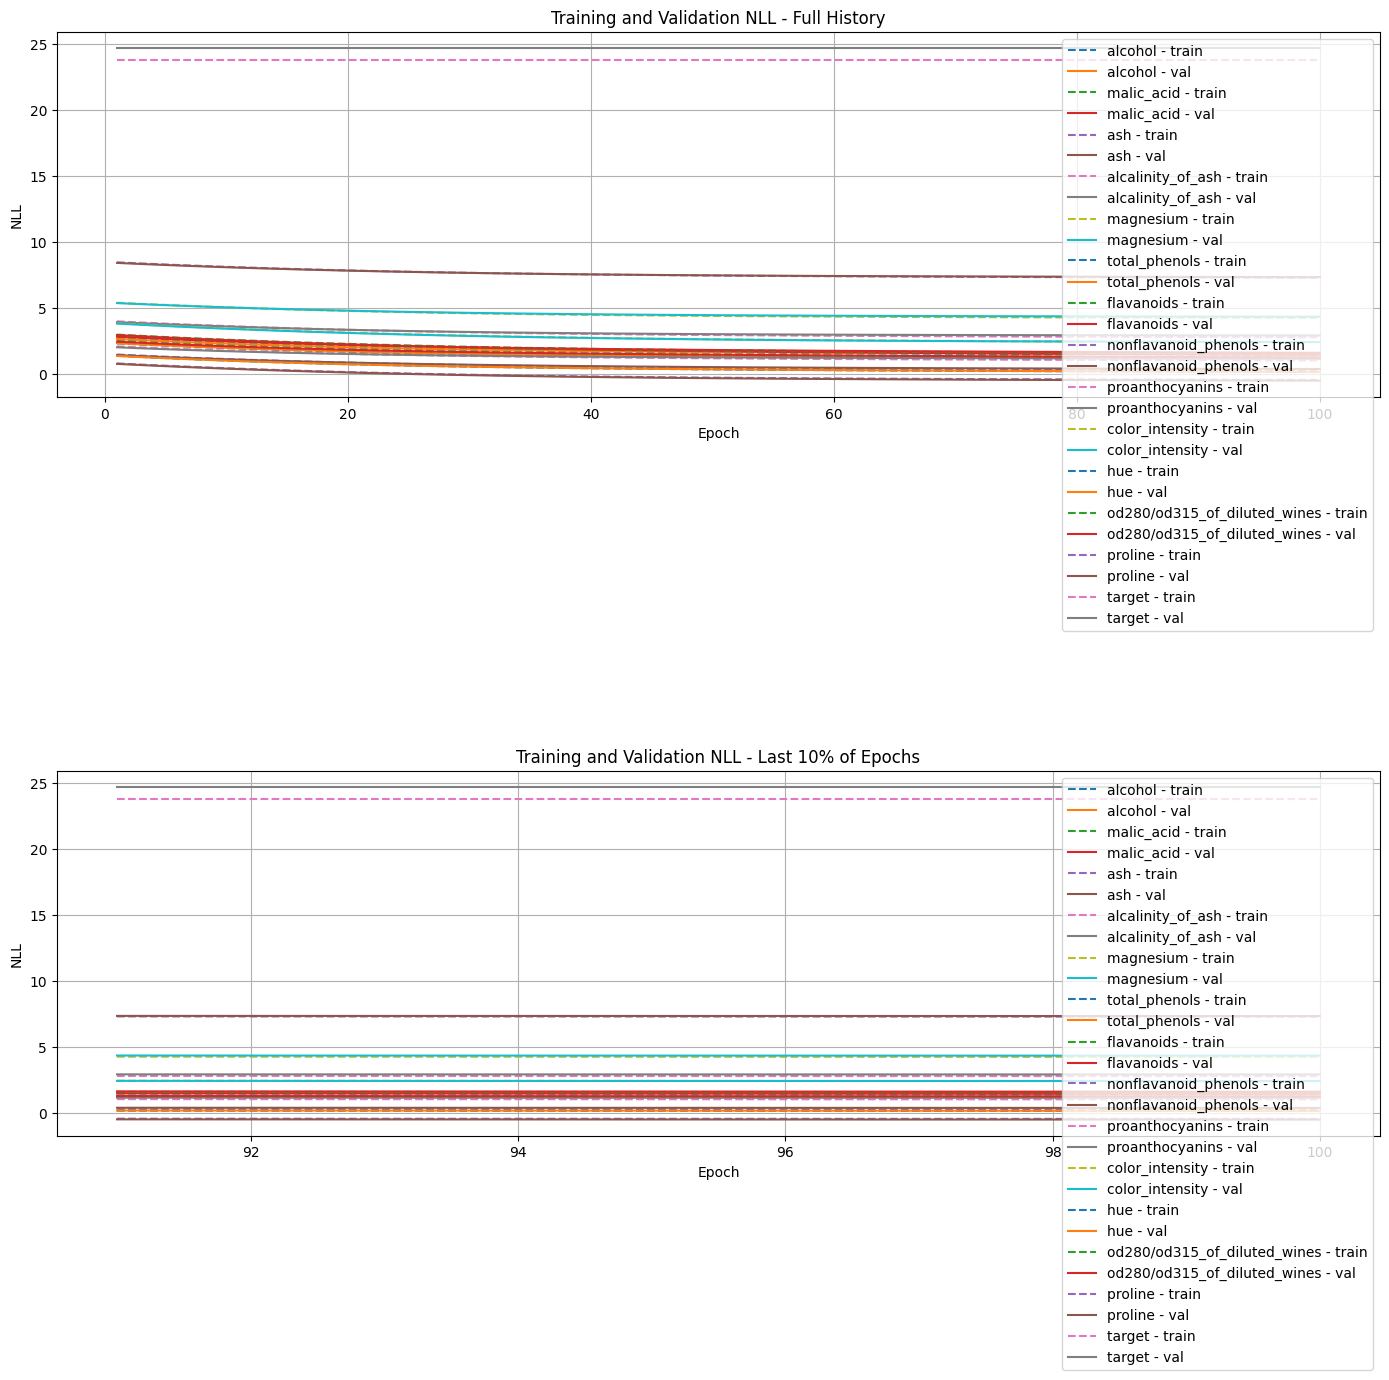

In [16]:
td_model.plot_loss_history()

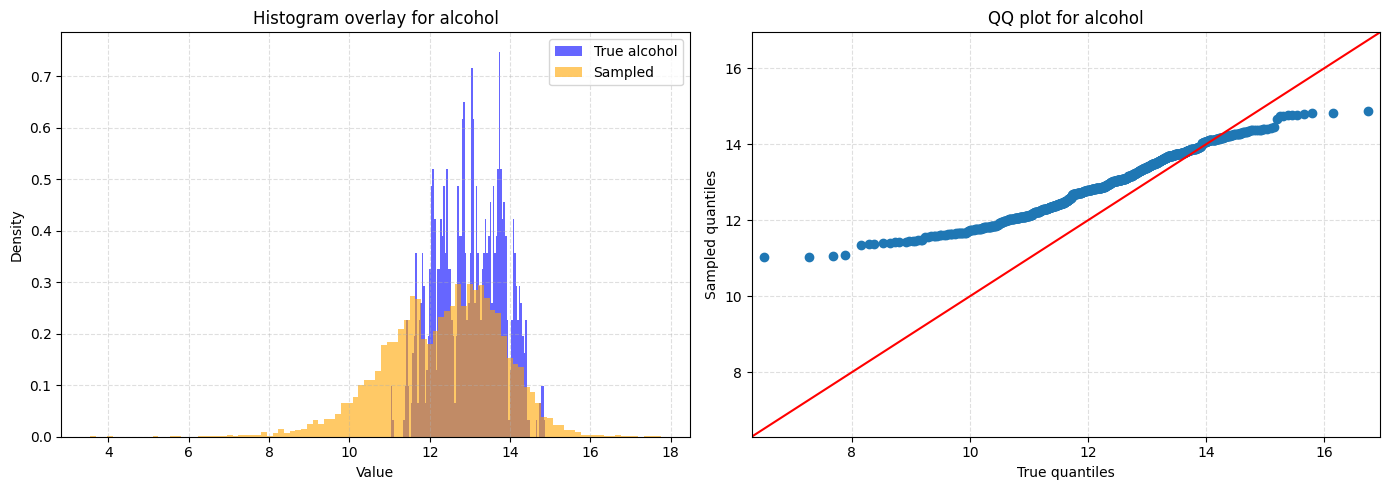

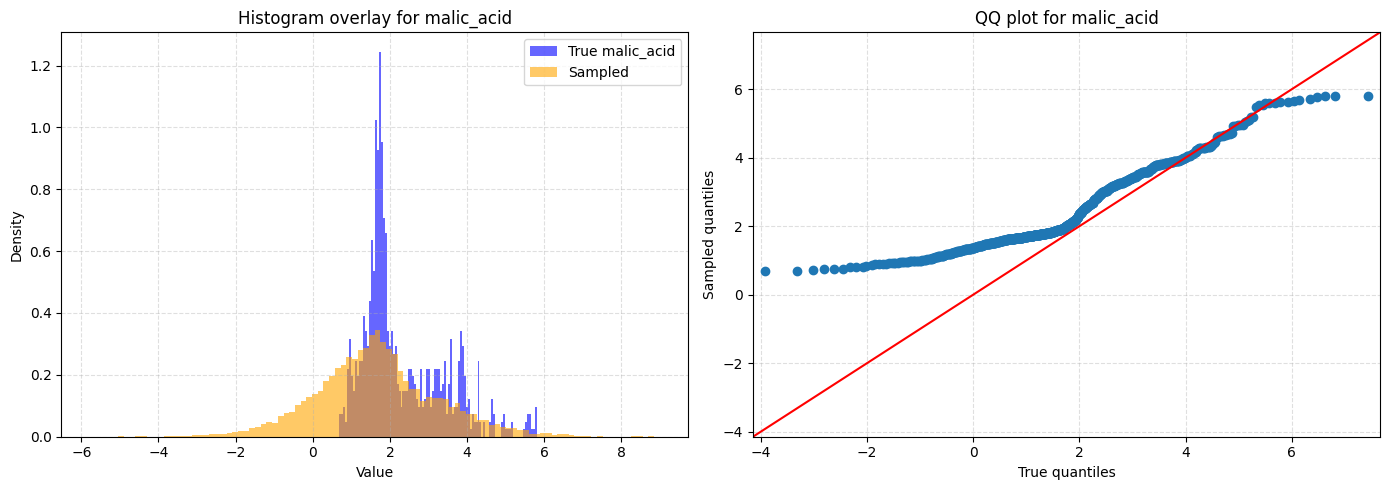

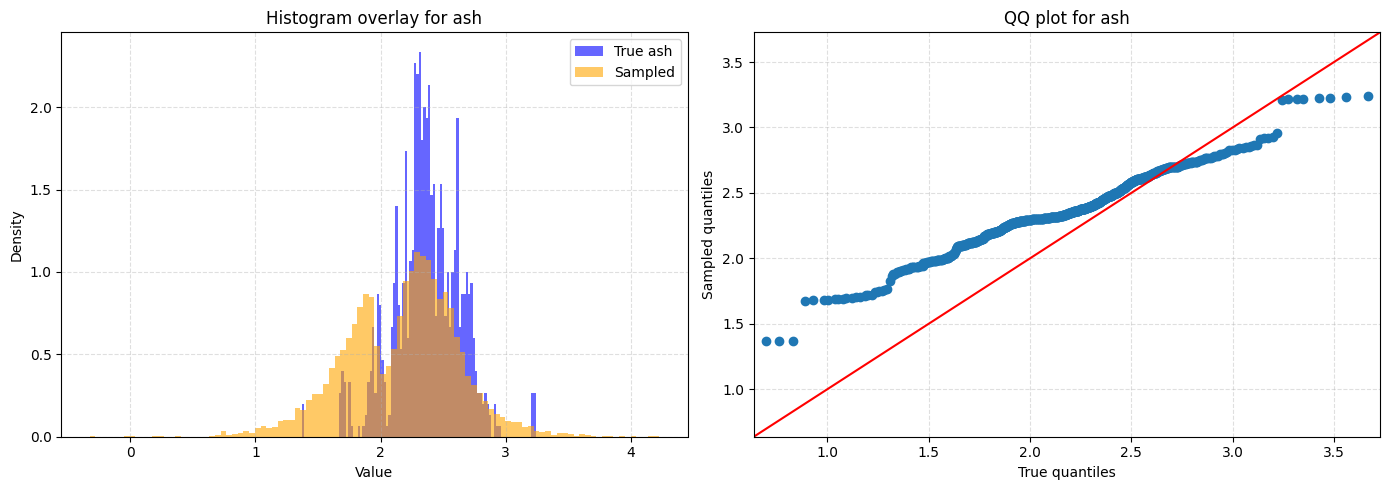

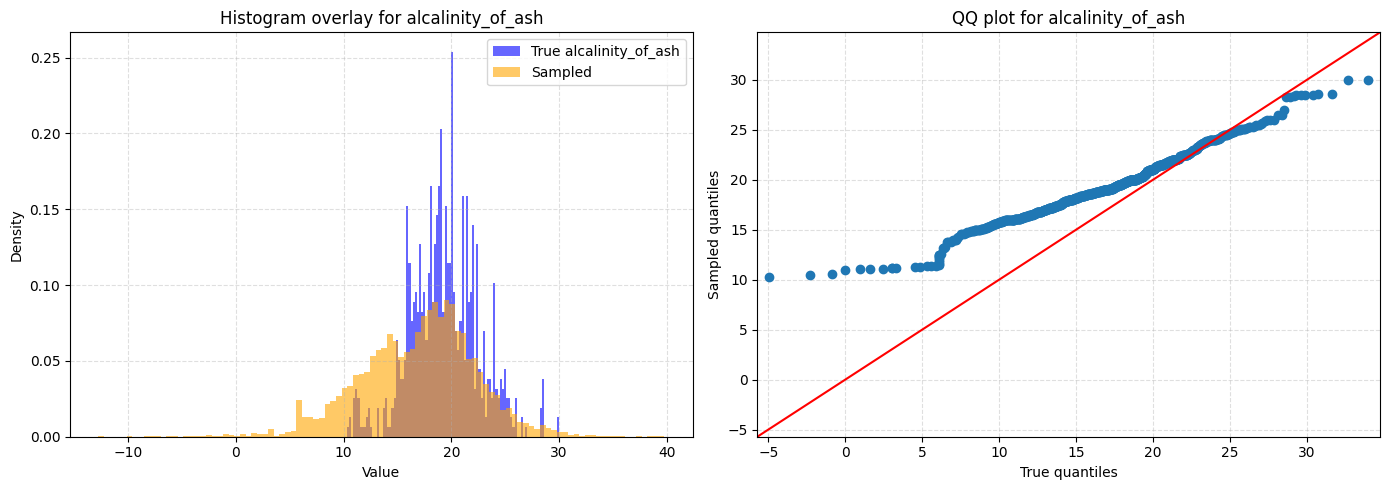

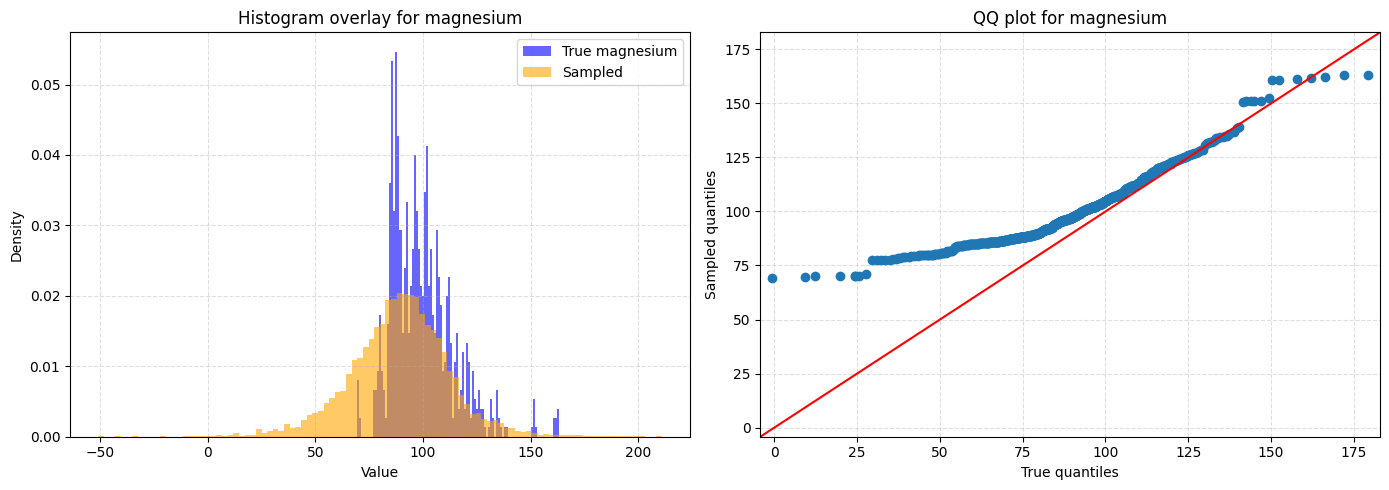

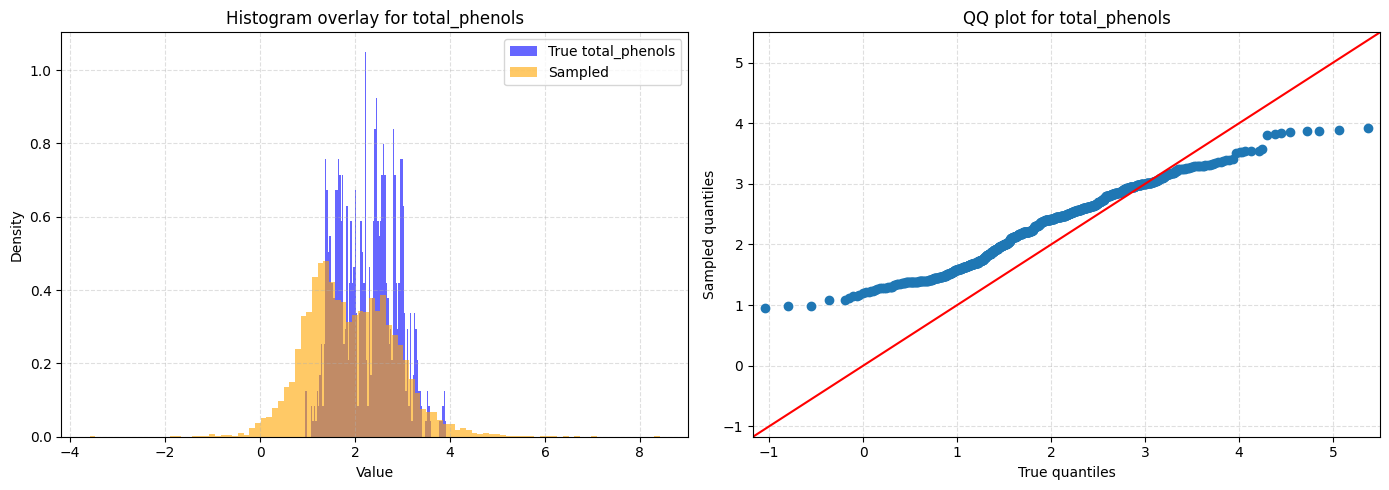

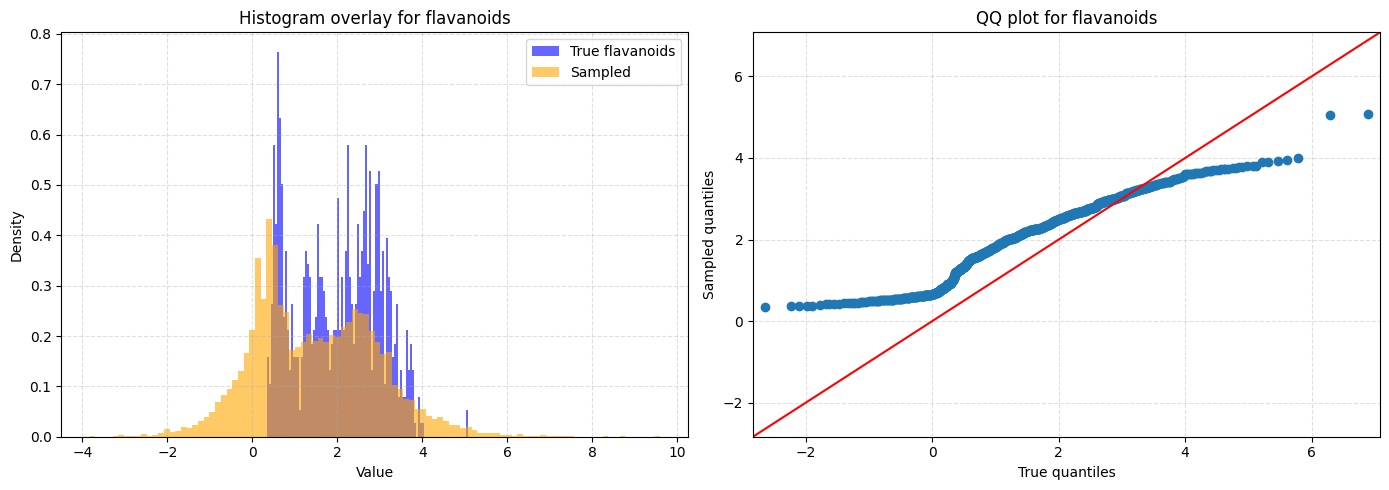

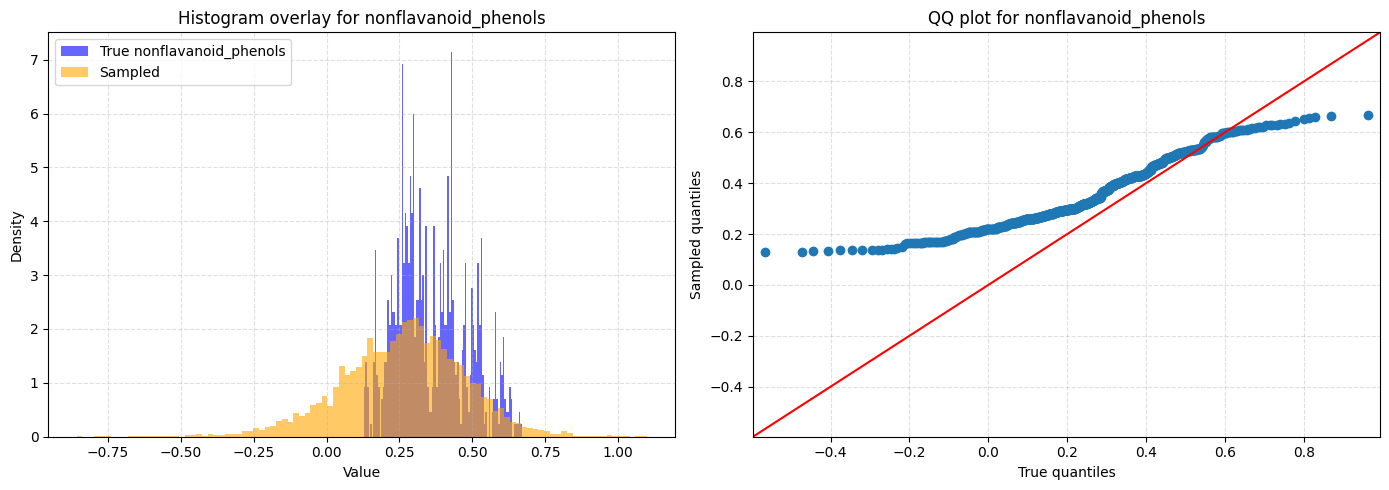

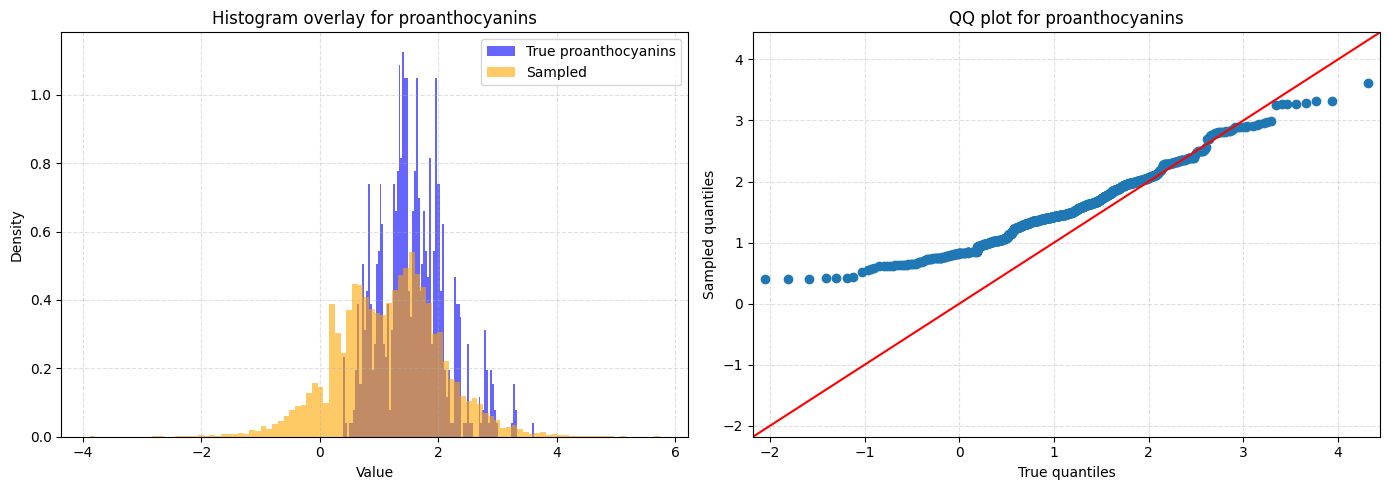

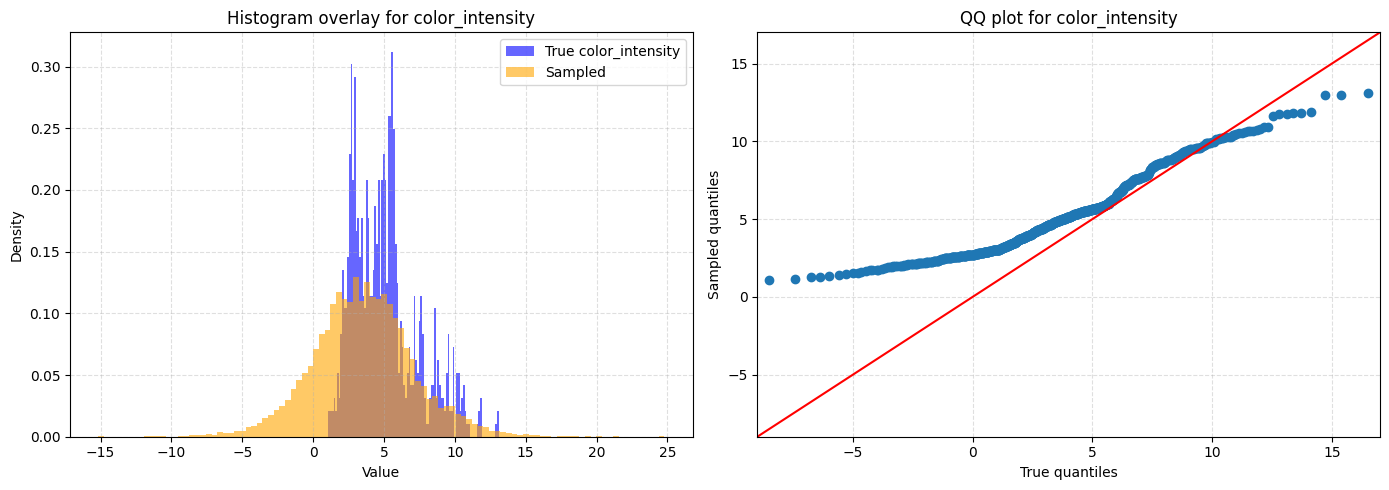

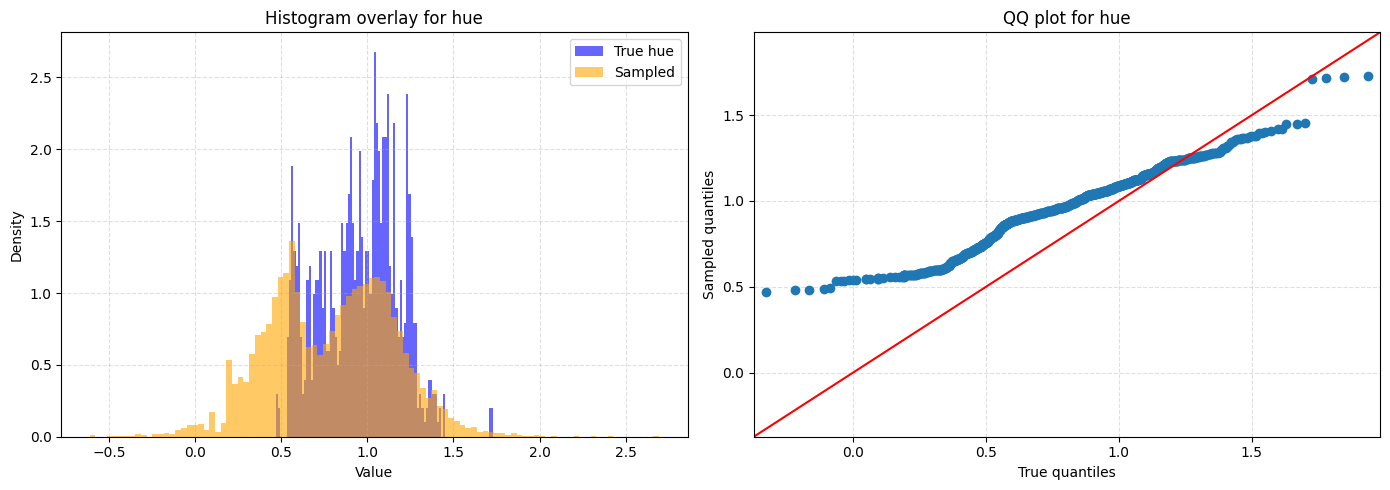

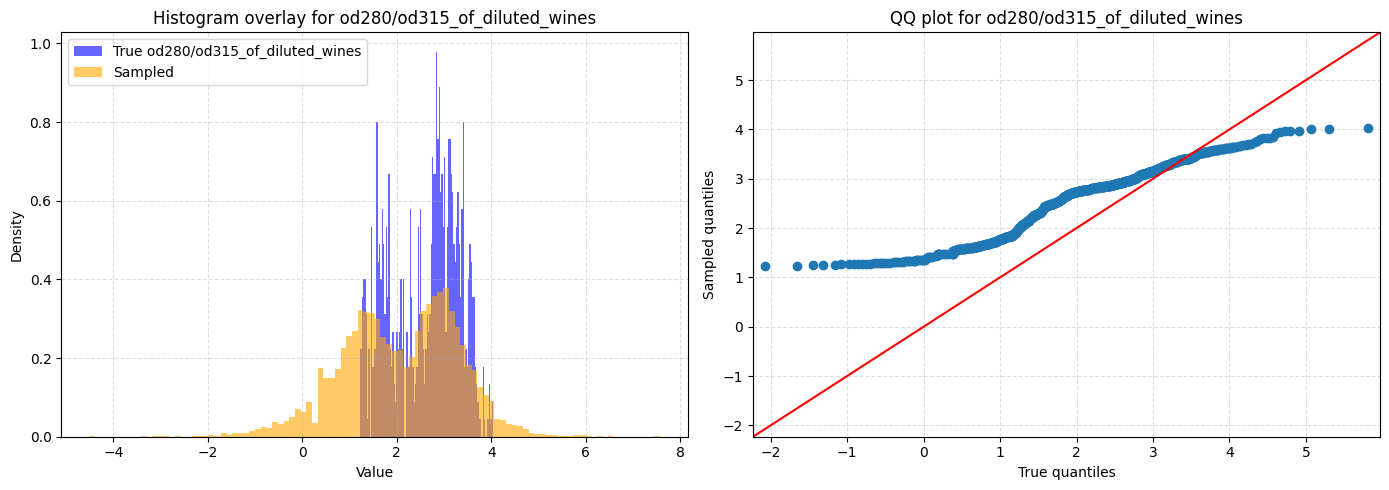

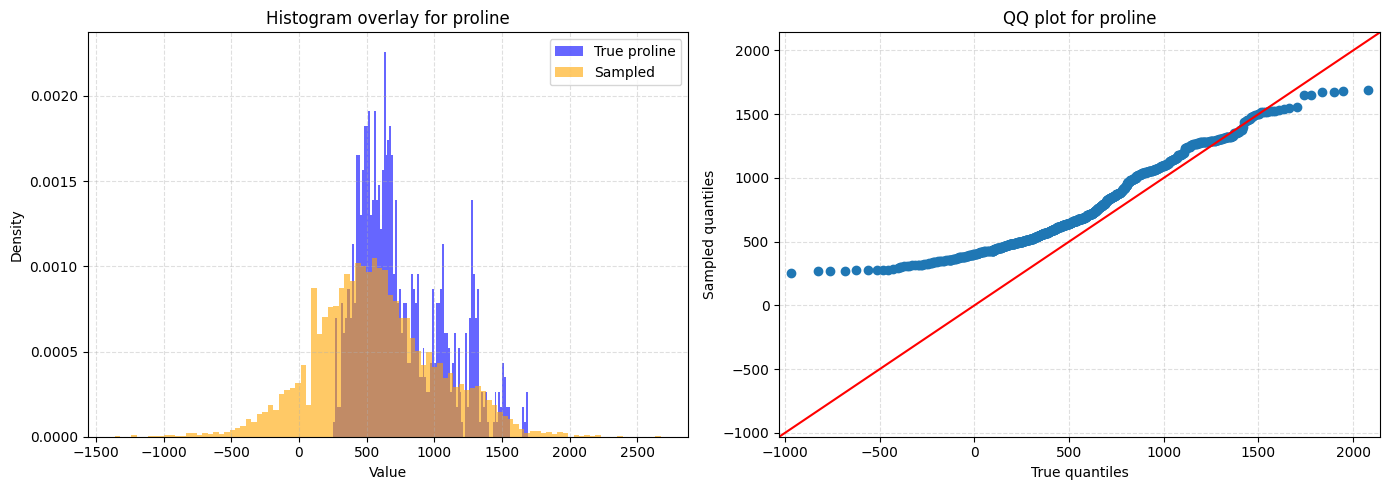

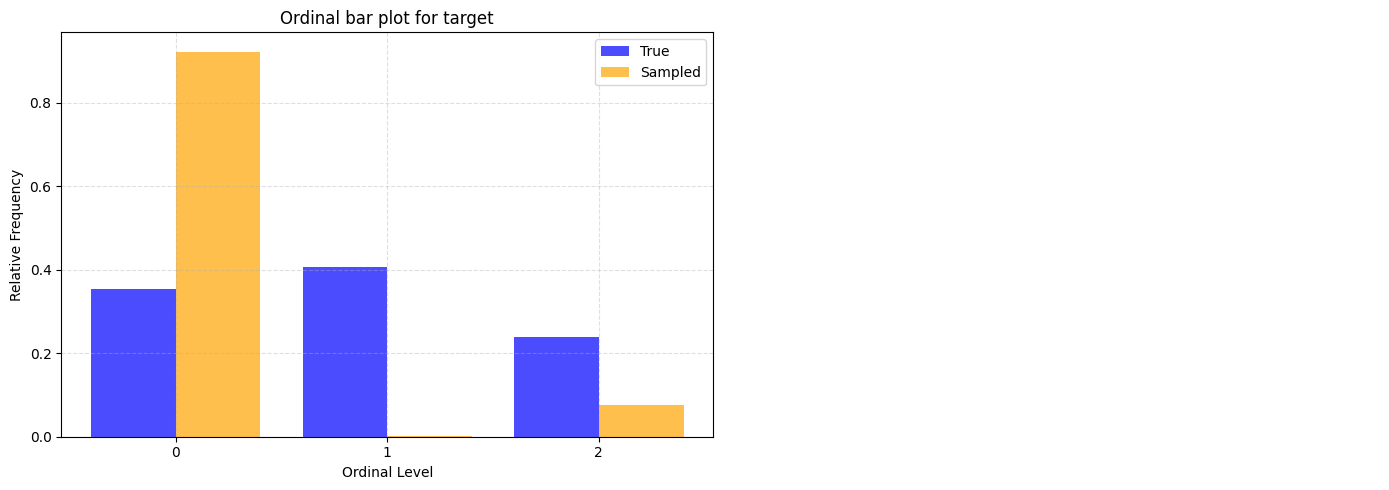

In [17]:
td_model.show_samples_vs_true(train_df)